In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt

from tqdm import tqdm

import feather

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost as xgb

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Lambda

from sklearn import preprocessing

from IPython.display import Audio
sound_file = './sound/beep.wav'



Using TensorFlow backend.


In [2]:
# Load in the time_series from the previous stage in the pipeline
correlations = feather.read_dataframe("../data_files/B/once/35days/5mins/best_correlations_5mins_code_hour_day.feather")
correlations = correlations.set_index(correlations.columns[0])


In [3]:
# time_series = feather.read_dataframe("../data_files/B/once/35days/10mins/diff_percent_from_code_hour_day_-_full_segment_time_series.feather")
# time_series = time_series.set_index(time_series.columns[0])

# time_series = time_series.rename(renamer, axis="columns")

In [4]:
stop_events = feather.read_dataframe("../data_files/B/once/35days/stop_events_with_geo_train_test_averages.feather")
stop_events = stop_events.set_index(stop_events.columns[0])

In [5]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

stop_events = filter_rare(stop_events)

Calculating rare segments...
	Calculated


In [6]:
# stop_events["arrival_1hour"] = stop_events["date"] + pd.to_timedelta(stop_events["arrival_hour"].values, unit="h")
# stop_events['offset_timestamp'] = stop_events["arrival_1hour"] - pd.Timedelta("1 hour")

stop_events["arrival_5mins"] = stop_events["actualArrival"].dt.round("5min")
stop_events['offset_timestamp'] = stop_events["arrival_5mins"] - pd.Timedelta("5 min")
# stop_events["offset_timestamp"] = stop_events["arrival_10mins"]

# print("##########################")
# print("##########################")
# print("    THIS IS A HACK!!!")
# print("##########################")
# print("##########################")


In [7]:
# We need to generate this from scratch as we need both test and train data. 
time_series = stop_events.pivot_table(
        index="arrival_5mins",
        columns="segment_code",
        values="diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day",
        aggfunc=np.median,
    )

In [8]:
time_series_interp = time_series.interpolate(method='time', axis=0)

In [9]:
weather = pd.read_csv("../weather/CDO9610867945337_weather.csv")


weather['date'] = pd.to_datetime(weather[' YEARMODA'], format="%Y%m%d")
weather['rain'] = weather['PRCP  '].apply(lambda x: float(x[:-1]))

just_rain = weather[['date', 'rain']]

In [10]:
stop_events = stop_events.merge(just_rain, left_on="date", right_on="date")

In [11]:
# stop_events[['best_0']]

In [12]:
stop_events = stop_events[['date', 'stopCode', 'aimedArrival', 'aimedDeparture', 'actualArrival', 'actualDeparture', 'prev_stopCode', 'prev_aimedArrival',
       'prev_aimedDeparture', 'prev_actualArrival', 'prev_actualDeparture',
       'timingPoint', 'prev_timingPoint', 'arrival_hour', 'segment_code', 'segment_name', 'line_distance', 'to_centre_dist', 'direction_degrees', 'train', 'test','full_duration','median_full_durations_by_segment_code',
       'median_full_durations_by_segment_code_and_hour',
       'median_full_durations_by_segment_code_and_hour_and_day',
       'diff_full_segment_and_median_by_segment_code',
       'diff_full_segment_and_median_by_segment_code_and_hour_and_day',
       'diff_percent_full_segment_and_median_by_segment_code',
       'diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day',
       'offset_timestamp', 'arrival_5mins', 'rain']]


In [13]:
stop_events = stop_events.merge(correlations, left_on="segment_code", right_index=True)

In [14]:
def best(row):
    try:
        value = time_series_interp.loc[row[0],row[1]] 
    except: 
#         print("--------------")
#         print(row.name)
#         print(row[0])
#         print(row[1])
        value = np.nan
    return value

In [15]:
stop_events['best_0'] = stop_events[['offset_timestamp', '0']].apply(best, axis=1)
stop_events['self_offset'] = stop_events[['offset_timestamp', 'segment_code']].apply(best, axis=1)

In [16]:
# stop_events = stop_events.dropna(subset=['best_0'])

# stop_events['best_0'] = stop_events['best_0'].replace([np.nan, -np.inf], 0)

In [17]:
# stop_events['best_1'] = stop_events[['offset_timestamp', '1']].apply(best, axis=1)
# # stop_events['best_1'] = stop_events['best_1'].replace([np.nan, -np.inf], 0)
# stop_events['best_2'] = stop_events[['offset_timestamp', '2']].apply(best, axis=1)
# # stop_events['best_2'] = stop_events['best_2'].replace([np.nan, -np.inf], 0)
# stop_events['best_3'] = stop_events[['offset_timestamp', '3']].apply(best, axis=1)
# # stop_events['best_3'] = stop_events['best_3'].replace([np.nan, -np.inf], 0)
# stop_events['best_4'] = stop_events[['offset_timestamp', '4']].apply(best, axis=1)

In [18]:
print(f"percent nan for best_0: {stop_events['best_0'].isna().sum()/stop_events.shape[0]*100}")
print(f"percent nan for self_offset: {stop_events['self_offset'].isna().sum()/stop_events.shape[0]*100}")

percent nan for best_0: 0.37409087903913285
percent nan for self_offset: 0.05254085379763102


In [19]:
stop_events['best_0'] = stop_events['best_0'].replace([np.nan, -np.inf], 0)
stop_events['self_offset'] = stop_events['self_offset'].replace([np.nan, -np.inf], 0)

In [20]:
stop_events = stop_events.dropna(axis=0)

In [21]:
# train_matrix = stop_events[stop_events['train']][['line_distance', 'to_centre_dist', 'direction_degrees', 'best_0', 'best_1', 'best_2', 'best_3', 'best_4', 'best_5', 'best_6', 'best_7', 'best_8', 'best_9', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39']].values
train_matrix = stop_events[stop_events['train']][['arrival_hour', 'line_distance', 'to_centre_dist', 'direction_degrees', 'best_0', '30', 'self_offset', 'rain']]
train_target = stop_events[stop_events['train']]['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'].values

# test_matrix = stop_events[stop_events['test']][['line_distance', 'to_centre_dist', 'direction_degrees', 'best_0', 'best_1', 'best_2', 'best_3', 'best_4', 'best_5', 'best_6', 'best_7', 'best_8', 'best_9', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39']].values
test_matrix = stop_events[stop_events['test']][['arrival_hour', 'line_distance', 'to_centre_dist', 'direction_degrees', 'best_0', '30', 'self_offset', 'rain']]
test_target = stop_events[stop_events['test']]['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'].values

test_target = np.nan_to_num(test_target)

In [22]:
stop_events.isna().sum(axis=0).max()

0

In [23]:
print(stop_events[stop_events['train']].shape)
print(train_matrix.shape)
print(train_target.shape)

(1653233, 94)
(1653233, 8)
(1653233,)


In [24]:
# stop_events['30']

In [25]:
reg = LinearRegression().fit(train_matrix, train_target)

reg_results = reg.predict(test_matrix)

In [26]:
reg.score(test_matrix, test_target)



0.4882085848019637

In [27]:
rmse_lr = np.sqrt(mean_squared_error(test_target, reg_results))
mae_lr = mean_absolute_error(test_target, reg_results)


In [28]:
print(rmse_lr)
print(mae_lr)


62.39801363563836
31.180895045734392


In [29]:
reg.coef_

array([-2.36277324e-02, -1.09939362e+01, -8.59189352e-02, -2.31033184e-03,
        4.52516598e-03,  1.39310692e+00,  7.75981631e-01,  8.05637090e-01])

In [30]:
data_dmatrix = xgb.DMatrix(data=train_matrix,label=train_target)


In [31]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gblinear', n_jobs=8, max_depth=5)

In [32]:
xg_reg.fit(train_matrix, train_target)

xg_reg_results = xg_reg.predict(test_matrix)

In [33]:
rmse_xg = np.sqrt(mean_squared_error(test_target, xg_reg_results))
mae_xg = mean_absolute_error(test_target, xg_reg_results)

In [34]:
print(rmse_xg)
print(mae_xg)

62.4048404603041
31.14611153241469


In [35]:
# xg_reg.feature_importances_

In [36]:
# scaler_matrix = preprocessing.StandardScaler().fit(train_matrix)

# train_matrix_scaled = scaler_matrix.transform(train_matrix)
# test_matrix_scaled = scaler_matrix.transform(test_matrix)

# scaler_target = preprocessing.StandardScaler().fit(train_target[:,None])

# train_target_scaled = scaler_target.transform(train_target[:,None])
# test_target_scaled = scaler_target.transform(test_target[:,None])




/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [37]:
# def create_fully_connected(input_width):
#     model = Sequential()
    
#     model.add(Dense(32, input_dim=input_width, activation='relu'))
#     model.add(layers.Dropout(0.2))
#     model.add(Dense(12, activation='relu'))
#     model.add(layers.Dropout(0.2))
#     model.add(Dense(12, activation='relu'))
#     model.add(layers.Dropout(0.2))
#     model.add(Dense(1, activation='tanh'))
#     model.summary()
    
#     return model

In [38]:
# model = create_fully_connected(train_matrix.shape[1])

# callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
#     keras.callbacks.ModelCheckpoint(filepath='full_conn_model.h5', monitor='val_loss', save_best_only=True)
# ]

# model.compile(optimizer='rmsprop',
#               loss='mean_absolute_error',
#               metrics=['MAE'])
# history = model.fit(train_matrix_scaled, train_target_scaled,
#                     epochs=10,
#                     callbacks=callbacks_list,
#                     batch_size=512,
#                     validation_data=(test_matrix_scaled, test_target_scaled))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                396       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_3 (Dropout)  

In [39]:
# model_to_load = 'full_conn_model.h5'

# # Create the network and load the weights into it
# model = create_fully_connected(test_matrix.shape[1])
# model.load_weights(model_to_load)

# model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['acc'])
# test_y_scaled = model.predict(test_matrix_scaled)

# NN_results = scaler_target.inverse_transform(test_y_scaled)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                288       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                396       
_________________________________________________________________
dropout_5 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_6 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total para

In [40]:
# rmse_NN = np.sqrt(mean_squared_error(test_target, NN_results))
# mae_NN = mean_absolute_error(test_target, NN_results)


In [41]:
# print(rmse_NN)
# print(mae_NN)

77.68256513362144
31.4909441815571


In [42]:
rmse_best_0 = np.sqrt(mean_squared_error(test_target, stop_events[stop_events['test']]['best_0']))
mae_best_0 = mean_absolute_error(test_target, stop_events[stop_events['test']]['best_0'])

In [43]:
print(rmse_best_0)
print(mae_best_0)

118.92237387346516
59.47977835314293


In [44]:
# plt.hist(NN_results, alpha=0.5, bins=100, label="NN", range=(-100, 100))
# plt.hist(xg_reg_results, bins=100, label="XGB", alpha=0.5,  range=(-100, 100))
# # plt.hist(reg_results, bins=100, label="Linear", alpha=0.5,  range=(-100, 100))
# plt.hist(stop_events[stop_events['test']]['best_0'], bins=100, alpha=0.5,  label="best_0", range=(-100, 100))
# # plt.hist(stop_events['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'], bins=200, label="target", range=(-100, 100))
# # plt.hist(train_target, bins=200, label="train", range=(-100, 100))
# plt.hist(test_target, bins=100, label="target", alpha=0.5,  range=(-100, 100))
# # plt.yscale("log")
# plt.legend()

# plt.show()


In [45]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [46]:
predict_reg = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(reg_results/100))

predict_xg = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(xg_reg_results/100))

# predict_NN = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(NN_results/100))

predict_best_0 = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(stop_events[stop_events['test']]['best_0']/100))

predict_self_offset = stop_events[stop_events['test']]["median_full_durations_by_segment_code_and_hour_and_day"] * (1+(stop_events[stop_events['test']]['self_offset']/100))


In [47]:
print(f"Linear MAPE: {MAPE(predict_reg, stop_events[stop_events['test']]['full_duration'])}")
      
print(f"XGBoost MAPE: {MAPE(predict_xg, stop_events[stop_events['test']]['full_duration'])}")
      
# print(f"NN MAPE: {MAPE(predict_NN, stop_events[stop_events['test']]['full_duration'])}")
            
print(f"Best_0 MAPE: {MAPE(predict_best_0, stop_events[stop_events['test']]['full_duration'])}")
      
print(f"self_offset MAPE: {MAPE(predict_self_offset, stop_events[stop_events['test']]['full_duration'])}")

Linear MAPE: 31.155251173599673
XGBoost MAPE: 31.067158691205243
Best_0 MAPE: 59.00974609745721
self_offset MAPE: 29.982495004895828


In [48]:
# plt.hist(stop_events['30'], bins=100);

In [49]:
# MAPE(stop_events[stop_events['test']]['median_full_durations_by_segment_code_and_hour_and_day'], stop_events[stop_events['test']]['full_duration'])


In [50]:
os.system("say -v Fiona Go check your results - predictions") 

0

In [51]:
# stop_events_dropped = stop_events[stop_events['best_0'] != 0]

# plt.hist(stop_events_dropped['best_0'], bins=100, range=(-100,100), alpha=0.5, label="0")
# plt.hist(stop_events_dropped['best_1'], bins=100, range=(-100,100), alpha=0.5, label="1")
# plt.hist(stop_events_dropped['best_2'], bins=100, range=(-100,100), alpha=0.5, label="2")
# plt.legend()
# plt.yscale("log")

In [52]:
np.mean(stop_events['best_0']**2)

5756.302886189739

In [53]:
events_per_segment = stop_events.groupby("segment_code").size()

In [54]:
events_per_segment.median()

1319.0

In [55]:
events_per_segment[events_per_segment > events_per_segment.median()].index

Index(['1200BOB20136_1200BOB20141_0.0', '1200BOB20137_1200DOB21235_0.0',
       '1200BOB20141_1200BOB20144_1.0', '1200BOB20142_1200DOY29325_1.0',
       '1200BOB20142_1200POA10900_0.0', '1200BOB20142_1200POA10900_1.0',
       '1200BOB20144_1200BOB20146_0.0', '1200BOB20146_1200BOB20149_0.0',
       '1200BOB20146_1200DOY38562_0.0', '1200BOB20147_1200BOB20142_0.0',
       ...
       '1290DOB21221_1290DOB21216_0.0', '1290DOB21222_1290DOB21223_0.0',
       '1290DOB21223_1290DOB21224_0.0', '1290DOB21224_1290DOB21225_0.0',
       '1290DOB21225_1290DOB21204_0.0', '1290POA11707_1280POA11708_1.0',
       '1290POA11715_1290POA11716_0.0', '1290POA11716_1290DOB20939_0.0',
       '1290POA11955_1290DOB20959_0.0', '1290POZ00750_1290BOB20070_1.0'],
      dtype='object', name='segment_code', length=495)

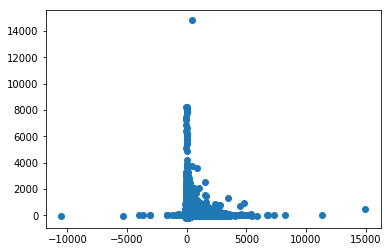

In [56]:
plt.scatter(stop_events['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'], stop_events['best_0'])


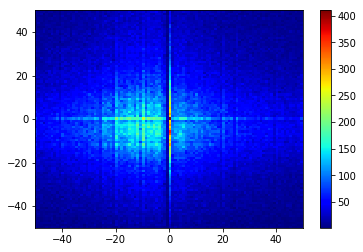

In [57]:
plt.hist2d(stop_events[stop_events['test']]['diff_percent_full_segment_and_median_by_segment_code_and_hour_and_day'], stop_events[stop_events['test']]['best_0'], bins=(100, 100), range=[[-50, 50], [-50, 50]], cmap=plt.cm.jet)
plt.colorbar()



In [58]:
events_per_segment = events_per_segment.to_frame().merge(stop_events.drop_duplicates(subset='segment_code'), how="left", on="segment_code")


In [59]:
events_per_segment.shape

(991, 95)

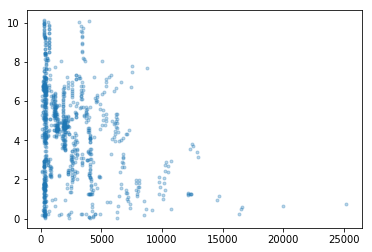

In [60]:
plt.scatter(events_per_segment[0], events_per_segment['to_centre_dist'], alpha=0.3, marker=".")

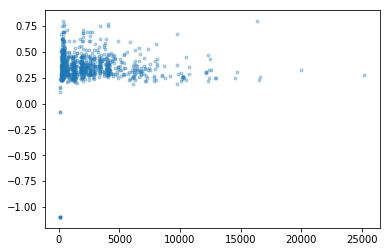

In [61]:
plt.scatter(events_per_segment[0], events_per_segment['30'], alpha=0.3, marker=".")

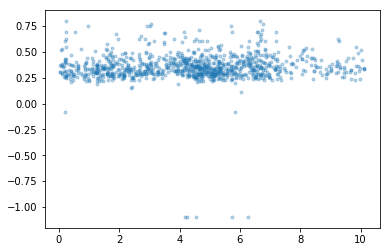

In [62]:
plt.scatter(events_per_segment['to_centre_dist'], events_per_segment['30'], alpha=0.3, marker=".")

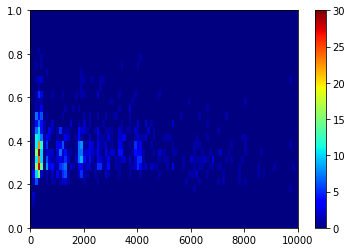

In [63]:
plt.hist2d(events_per_segment[0], events_per_segment['30'], bins=(100, 30), range=[[0, 10000], [0, 1]], cmap=plt.cm.jet)
plt.colorbar()



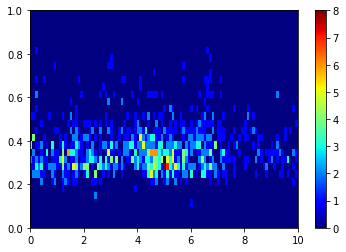

In [64]:
plt.hist2d(events_per_segment['to_centre_dist'], events_per_segment['30'], bins=(100, 30), range=[[0, 10], [0, 1]], cmap=plt.cm.jet)
plt.colorbar()

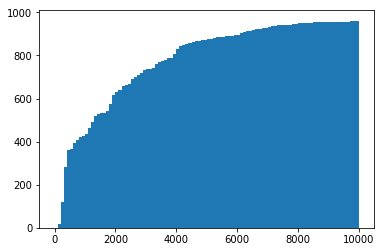

In [65]:
plt.hist(events_per_segment[0], cumulative=True, bins=100, range=(0,10000));

In [66]:
np.count_nonzero(events_per_segment[0] > events_per_segment[0].median())

495

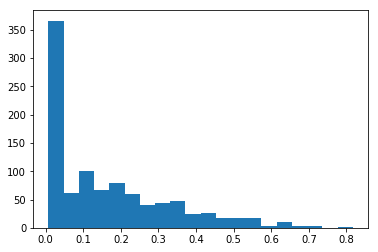

In [67]:
plt.hist(time_series.count()/time_series.shape[0], bins=20);

In [68]:
time_series.shape[0]

11457

In [69]:
time_series.columns[(time_series.count()>(5760/3))]

Index(['1200BOB20136_1200BOB20141_0.0', '1200BOB20137_1200DOB21235_0.0',
       '1200BOB20141_1200BOB20144_1.0', '1200BOB20142_1200DOY29325_1.0',
       '1200BOB20142_1200POA10900_0.0', '1200BOB20142_1200POA10900_1.0',
       '1200BOB20144_1200BOB20146_0.0', '1200BOB20146_1200BOB20149_0.0',
       '1200BOB20146_1200DOY38562_0.0', '1200BOB20147_1200BOB20142_0.0',
       ...
       '1290DOB21218_1290BOB20312_0.0', '1290DOB21219_1290DOB21220_0.0',
       '1290DOB21220_1290DOB21221_0.0', '1290DOB21221_1290DOB21216_0.0',
       '1290DOB21222_1290DOB21223_0.0', '1290DOB21223_1290DOB21224_0.0',
       '1290DOB21224_1290DOB21225_0.0', '1290DOB21225_1290DOB21204_0.0',
       '1290POA11955_1290DOB20959_0.0', '1290POZ00750_1290BOB20070_1.0'],
      dtype='object', name='segment_code', length=404)